# VAE Demo
The aim of this notebook is to demonstrate how to use our framework on a simple VAE example.

### Data importation

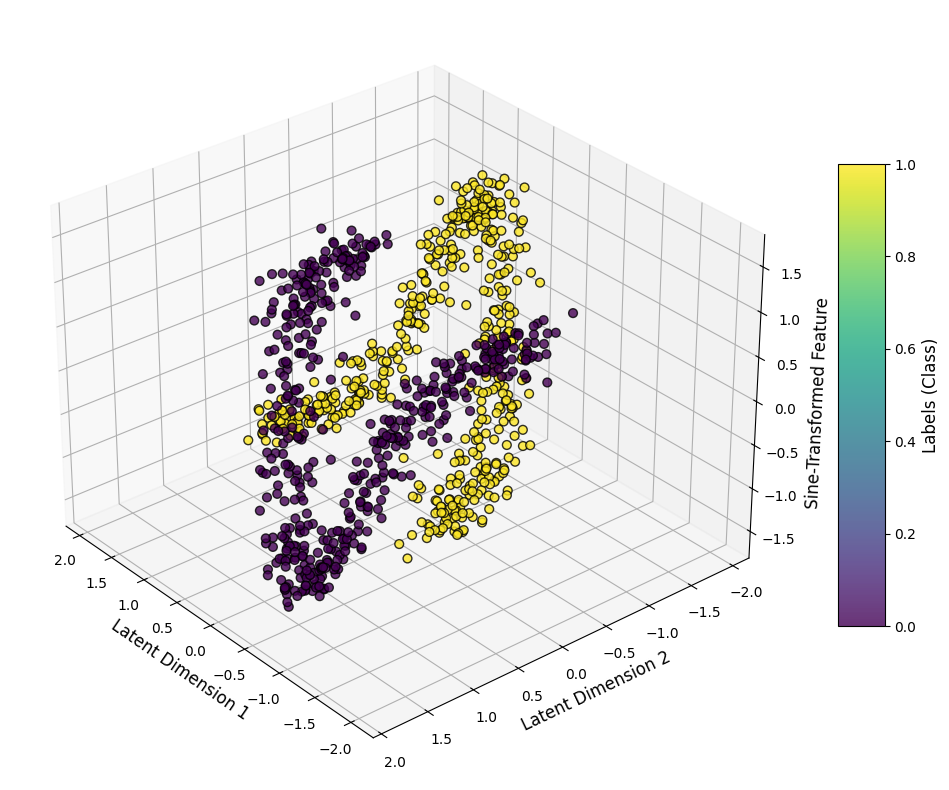

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from framework.data import generate_synthetic_data

data = generate_synthetic_data(4000, 0.1, 2)
X_train = data[0]
X_train_labels = data[1]

data_test = generate_synthetic_data(1000, 0.1, 2)
X_test = data_test[0]
X_test_labels = data_test[1]
N_train, D = X_train.shape

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d', azim=140, elev=30)
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                     c=X_test_labels.ravel(), cmap='viridis', s=40, alpha=0.8, edgecolor='k')

# Customization
ax.set_xlabel("Latent Dimension 1", fontsize=12)
ax.set_ylabel("Latent Dimension 2", fontsize=12)
ax.set_zlabel("Sine-Transformed Feature", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)
cbar.set_label("Labels (Class)", fontsize=12)

# Styling and save
plt.tight_layout()
plt.show()

In [2]:
from torch_geometric.data import Data, DataLoader
from framework.visuals import *

latent_dim = 2
input_dim = D
batch_size = 32
dropout = 0
epochs = 2000

encoder_hidden_dims=[128, 64, 32]
decoder_hidden_dims=[1028]#[32, 64, 128]

device = "cuda" if torch.cuda.is_available() else "cpu"

x_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(X_train_labels, dtype=torch.long)

x_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(X_test_labels, dtype=torch.long)

# Create training dataset
train_data = Data(x=x_train_tensor, y=y_train_tensor)

# Create testing dataset
test_data = Data(x=x_test_tensor, y=y_test_tensor)

train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)





/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

### VAE definition

In [3]:
import torch
from framework.encoder import MLPEncoder

encoder = MLPEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=encoder_hidden_dims,
    mlp_layers=len(encoder_hidden_dims),
    dropout=dropout,
    activation=torch.nn.ELU()
)

from framework.decoder import MLPDecoder

decoder = MLPDecoder(
    latent_dim=latent_dim,
    out_dim=input_dim,
    hidden_dims=decoder_hidden_dims,
    dropout=dropout,
    activation=torch.nn.ELU
)

from framework.GraphVAE import KLAnnealingScheduler

kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.1,
    anneal_steps=epochs,
    anneal_type='linear'
)

In [4]:
import torch.nn as nn
from typing import Dict, List, Optional, Tuple, Any, Callable
from abc import ABC, abstractmethod


from framework.encoder import Encoder
from framework.decoder import DecoderBase
from framework.GraphVAE import KLAnnealingScheduler


class VAE(nn.Module):
    """
    Flexible VAE model supporting multiple decoders and pluggable priors
    """
    def __init__(
        self,
        encoder: "Encoder",
        decoders: List["DecoderBase"],
        prior: Optional["Prior"] = None,
        kl_scheduler: Optional["KLAnnealingScheduler"] = None,
        freeze_encoder: bool = False
    ):
        """
        Args:
            encoder: Encoder modules
            decoders: List of decoder modules
            prior: Prior distribution (defaults to GaussianPrior)
            kl_scheduler: Optional KL annealing scheduler
            freeze_encoder: Whether to freeze the encoder parameters
        """
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoders = nn.ModuleList(decoders)
        self.decoder_dict = {decoder.name: decoder for decoder in decoders}
        self.prior = prior if prior is not None else GaussianPrior()
        self.prior.giveVAEInstance(self)  
        self.kl_scheduler = kl_scheduler if kl_scheduler else KLAnnealingScheduler()
        
        # Set encoder freeze state
        self.set_encoder_freeze(freeze_encoder)
        
    def set_encoder_freeze(self, freeze: bool = True):
        """
        Freeze or unfreeze encoder parameters
        
        Args:
            freeze: Whether to freeze encoder parameters
        """
        for param in self.encoder.parameters():
            param.requires_grad = not freeze
            
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode graph into latent space
        
        Args:
            x: Node features [num_nodes, input_dim]
            
        Returns:
            mu: Mean of latent distribution
            params: Distribution parameters (e.g., logvar for Gaussian)
        """
        return self.encoder(x)
    
    def reparameterize(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from latent distribution
        
        Args:
            mu: Mean of latent distribution
            params: Distribution parameters
            
        Returns:
            Sampled latent variables
        """
        return self.prior.sample(mu, params)
    
    def decode(self, z: torch.Tensor, **kwargs) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Decode latent variables through all active decoders
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict of outputs from each decoder
        """
        all_outputs = {}
        
        for decoder in self.decoders:
            decoder_kwargs = {k: v for k, v in kwargs.items() 
                              if k in decoder.forward.__code__.co_varnames}
            outputs = decoder(z, **decoder_kwargs)
            all_outputs[decoder.name] = outputs
        
        return all_outputs
    
    def forward(self, x: torch.Tensor, **kwargs) -> Dict[str, Any]:
        """
        Full forward pass
        
        Args:
            x: Node features [num_nodes, input_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict with outputs and latent variables
        """
        # Encode
        mu, params = self.encode(x)
        
        # Sample latent variables
        z = self.reparameterize(mu, params)
        
        # Decode
        decoder_kwargs = {**kwargs}
        outputs = self.decode(z, **decoder_kwargs)
        
        return {
            "mu": mu,
            "params": params,
            "z": z,
            "outputs": outputs
        }
    
    def compute_loss(
        self, 
        outputs: Dict[str, Any], 
        targets: Dict[str, Dict[str, torch.Tensor]],
        decoder_weights: Optional[Dict[str, float]] = None,
        active_decoders: Optional[List[str]] = None,
        use_custom_losses: bool = True
    ) -> Dict[str, torch.Tensor]:
        """
        Compute total loss from VAE components
        
        Args:
            outputs: Outputs from forward pass
            targets: Target values for each decoder
            decoder_weights: Optional weights for each decoder loss
            active_decoders: Optional list of decoder names to include in loss computation
            use_custom_losses: Whether to include custom decoder losses
            
        Returns:
            Dict with total loss and component losses
        """
        # Default weights if not provided
        if decoder_weights is None:
            decoder_weights = {decoder.name: 1.0 for decoder in self.decoders}
        
        # Use all decoders if active_decoders not specified
        if active_decoders is None:
            active_decoders = list(self.decoder_dict.keys())
        
        # KL divergence loss using pluggable prior
        mu, params = outputs["mu"], outputs["params"]
        kl_loss = self.prior.kl_divergence(mu, params)
        
        # Get current KL weight from scheduler
        kl_weight = self.kl_scheduler.get_weight()
        
        # Compute individual decoder losses
        decoder_losses = {}
        detailed_losses = {}
        weighted_recon_loss = 0
        
        z = outputs["z"]  # Get latent variables for custom losses
        
        for decoder in self.decoders:
            name = decoder.name
            if name not in outputs["outputs"] or name not in active_decoders:
                continue
                
            # Get decoder outputs and corresponding targets
            decoder_outputs = outputs["outputs"][name]
            decoder_targets = targets.get(name, {})
            
            # Compute loss for this decoder (including custom losses if enabled)
            if use_custom_losses and hasattr(decoder, 'compute_total_loss'):
                loss_breakdown = decoder.compute_total_loss(
                    decoder_outputs, decoder_targets, z=z
                )
                decoder_loss = loss_breakdown['total']
                detailed_losses[name] = loss_breakdown
            else:
                decoder_loss = decoder.compute_loss(decoder_outputs, decoder_targets)
                detailed_losses[name] = {'base_loss': decoder_loss, 'total': decoder_loss}
            
            decoder_losses[name] = decoder_loss
            
            # Add weighted loss to total reconstruction loss
            decoder_weight = decoder_weights.get(name, 1.0)
            weighted_recon_loss += decoder_weight * decoder_loss
        
        # Compute total loss
        total_loss = weighted_recon_loss + kl_weight * kl_loss
        
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "kl_weight": kl_weight,
            "recon_loss": weighted_recon_loss,
            "decoder_losses": decoder_losses,
            "detailed_losses": detailed_losses
        }
    
    def add_decoder(self, decoder: "DecoderBase"):
        """
        Add a new decoder to the model
        
        Args:
            decoder: Decoder module to add
        """
        self.decoders.append(decoder)
        self.decoder_dict[decoder.name] = decoder
    
    def remove_decoder(self, name: str) -> bool:
        """
        Remove a decoder by name
        
        Args:
            name: Name of the decoder to remove
            
        Returns:
            True if decoder was removed, False if not found
        """
        if name in self.decoder_dict:
            decoder = self.decoder_dict[name]
            self.decoders = nn.ModuleList([d for d in self.decoders if d.name != name])
            self.decoder_dict.pop(name)
            return True
        return False
    
    def get_decoder(self, name: str) -> Optional["DecoderBase"]:
        """
        Get decoder by name
        
        Args:
            name: Name of the decoder
            
        Returns:
            Decoder module or None if not found
        """
        return self.decoder_dict.get(name)
    
    def get_active_decoders(self) -> List[str]:
        """
        Get names of all active decoders
        
        Returns:
            List of decoder names
        """
        return list(self.decoder_dict.keys())
    
    def compute_jacobian(self, z: torch.Tensor, decoder_name: str, node_idx: Optional[int] = None) -> torch.Tensor:
        """
        Compute Jacobian of a specific decoder with respect to latent space
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            decoder_name: Name of the decoder to compute Jacobian for
            node_idx: Optional node index to compute Jacobian for
            
        Returns:
            Jacobian matrix
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
            
        if hasattr(decoder, "compute_jacobian"):
            return decoder.compute_jacobian(z, node_idx)
        else:
            raise NotImplementedError(f"Decoder '{decoder_name}' does not implement compute_jacobian method")
    
    # Convenience methods for managing custom losses
    def add_custom_loss_to_decoder(self, decoder_name: str, loss_name: str, 
                                  loss_fn: Callable, weight: float = 1.0):
        """
        Add a custom loss to a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name for the custom loss
            loss_fn: Loss function
            weight: Weight for the loss
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
        decoder.add_custom_loss(loss_name, loss_fn, weight)
    
    def remove_custom_loss_from_decoder(self, decoder_name: str, loss_name: str):
        """
        Remove a custom loss from a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss to remove
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.remove_custom_loss(loss_name)
    
    def set_custom_loss_active(self, decoder_name: str, loss_name: str, active: bool = True):
        """
        Activate/deactivate a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            active: Whether the loss should be active
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_active(loss_name, active)
    
    def set_custom_loss_weight(self, decoder_name: str, loss_name: str, weight: float):
        """
        Update the weight of a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            weight: New weight value
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_weight(loss_name, weight)


class Prior(ABC):
    """Abstract base class for priors"""

    def giveVAEInstance(self, model: VAE):
        self.model = model
    
    @abstractmethod
    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Sample from the prior distribution"""
        pass
    
    @abstractmethod
    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Compute KL divergence with respect to the prior"""
        pass
    
    @abstractmethod
    def get_param_size(self) -> int:
        """Return the number of parameters needed (e.g., 1 for logvar, 2 for concentration)"""
        pass

class GaussianPrior(Prior):
    """Gaussian prior N(0, I)"""
    
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        if mu.device != logvar.device:
            logvar = logvar.to(mu.device)
        
        if mu.requires_grad:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def kl_divergence(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    def get_param_size(self) -> int:
        return 1  # logvar


# Example usage:
"""
# Gaussian VAE
gaussian_vae = VAE(
    encoder=my_encoder,
    decoders=[my_decoder],
    prior=GaussianPrior()
)

# von Mises-Fisher VAE for hyperspherical latent space
vmf_vae = VAE(
    encoder=my_encoder,
    decoders=[my_decoder],
    prior=VonMisesPrior(kappa=2.0)
)
"""

'\n# Gaussian VAE\ngaussian_vae = VAE(\n    encoder=my_encoder,\n    decoders=[my_decoder],\n    prior=GaussianPrior()\n)\n\n# von Mises-Fisher VAE for hyperspherical latent space\nvmf_vae = VAE(\n    encoder=my_encoder,\n    decoders=[my_decoder],\n    prior=VonMisesPrior(kappa=2.0)\n)\n'

In [ ]:
# class RiemannianPrior(Prior):
#     """Riemannian Brownian motion prior on latent manifold"""
#     def __init__(self, variance: float = 1.0,
#         distance_mode: str = "linear_interpolation",  # or "direct"
#         num_integration_points: int = 10,
#         metric_regularization: float = 1e-6,
#         cache_jacobians: bool = True,
#         # Simple caching parameters
#         cache_tolerance: float = 1e-4,  # How close points need to be to reuse cache
#         max_cache_size: int = 1000,  # Maximum cached entries
#         ):
#         """
#         Args:
#             variance: diffusion time parameter t controlling spread of Brownian motion
#         """
#         self._reference_decoder = None
#         self.variance = variance

#         self.distance_mode = distance_mode
#         self.num_integration_points = num_integration_points
#         self.metric_regularization = metric_regularization
#         self.cache_jacobians = cache_jacobians
#         self.cache_tolerance = cache_tolerance
#         self.max_cache_size = max_cache_size
#         # Simple cache: store (z_point_hash, metric_tensor) pairs
#         self._metric_cache = {}  # Key: simple hash -> (z_point, metric_tensor_detached)
#         self._jacobian_cache = {}
#         self._cache_valid = False
#         self._reference_decoder = None

#     def _get_cache_key(self, z_point: torch.Tensor) -> str:
#         """Generate a simple cache key from z_point"""
#         z_rounded = torch.round(z_point / self.cache_tolerance) * self.cache_tolerance
#         z_str = "_".join([f"{float(x):.6f}" for x in z_rounded.detach().numpy()])
#         return z_str

#     def _find_cached_metric(self, z_point: torch.Tensor) -> Optional[torch.Tensor]:
#         """Find cached metric tensor for similar z_point"""
#         cache_key = self._get_cache_key(z_point)
#         if cache_key in self._metric_cache:
#             cached_z, cached_metric = self._metric_cache[cache_key]
#             if torch.norm(z_point - cached_z) < self.cache_tolerance:
#                 return cached_metric.to(device=z_point.device, dtype=z_point.dtype)
#         return None

#     def _cache_metric(self, z_point: torch.Tensor, metric_tensor: torch.Tensor):
#         """Cache a metric tensor"""
#         if len(self._metric_cache) >= self.max_cache_size:
#             oldest_key = next(iter(self._metric_cache))
#             del self._metric_cache[oldest_key]
#         cache_key = self._get_cache_key(z_point)
#         self._metric_cache[cache_key] = (z_point.detach().clone(), metric_tensor.detach().clone())

#     def _compute_metric_raw(self, z_point: torch.Tensor) -> torch.Tensor:
#         """Raw computation of metric tensor without caching"""
#         if self._reference_decoder is None:
#             self.set_reference_decoder(self.model.get_active_decoders()[0])  

#         # Old-style jacobian cache
#         cache_key = hash(z_point.detach().numpy().tobytes())
#         if self.cache_jacobians and cache_key in self._jacobian_cache:
#             return self._jacobian_cache[cache_key]

#         try:
#             # Compute Jacobian at this point
#             # Assume decoder returns [output_dim, latent_dim]
#             jacobian = self._reference_decoder.compute_jacobian(z_point)

#             if jacobian.dim() == 2:
#                 metric = torch.mm(jacobian.t(), jacobian)
#             elif jacobian.dim() == 1 and jacobian.size(0) == self.model.encoder.latent_dim:
#                 metric = torch.outer(jacobian, jacobian)
#             else:
#                 raise ValueError(f"Unexpected Jacobian shape: {jacobian.shape}")

#             # Regularize
#             metric = metric + self.metric_regularization * torch.eye(
#                 self.model.encoder.latent_dim, device=z_point.device, dtype=z_point.dtype
#             )

#             if self.cache_jacobians:
#                 self._jacobian_cache[cache_key] = metric
#             return metric

#         except Exception as e:
#             print(f"Warning: Falling back to identity metric: {e}")
#             return torch.eye(self.model.encoder.latent_dim, device=z_point.device, dtype=z_point.dtype)

#     def _compute_metric_tensor(self, z_point: torch.Tensor) -> torch.Tensor:
#         """Compute (and cache) the metric tensor at z_point"""
#         cached = self._find_cached_metric(z_point)
#         if cached is not None:
#             actual = self._compute_metric_raw(z_point)
#             return cached + 0.0 * actual

#         metric = self._compute_metric_raw(z_point)
#         if self.cache_jacobians:
#             self._cache_metric(z_point, metric)
#         return metric

#     def _distance_linear_interpolation(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
#         """Distance via linear interpolation with Jacobian-based metric"""
#         def integrand(t):
#             x_t = t * u + (1 - t) * v
#             G = self._compute_metric_tensor(x_t)
#             diff = u - v
#             q = torch.sum(diff * (G @ diff))
#             return torch.sqrt(torch.clamp(q, min=1e-8))

#         t_vals = torch.linspace(0, 1, self.num_integration_points, device=u.device)
#         dt = 1.0 / (self.num_integration_points - 1)
#         vals = torch.stack([integrand(t) for t in t_vals])
#         return torch.trapz(vals, dx=dt)

#     def _distance_midpoint(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
#         """Distance via metric at midpoint"""
#         mid = (u + v) / 2
#         G = self._compute_metric_tensor(mid)
#         diff = u - v
#         q = torch.sum(diff * (G @ diff))
#         return torch.sqrt(torch.clamp(q, min=1e-8))
    
#     def _compute_pairwise_distance(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
#         """Compute distance between two points using selected mode"""
#         if self.distance_mode == "linear_interpolation":
#             return self._distance_linear_interpolation(u, v)
#         else:
#             return self._distance_midpoint(u, v)

#     def set_reference_decoder(self, decoder: "DecoderBase"):
#         """Set the reference decoder used for Jacobian computation"""
#         self._reference_decoder = self.model.get_decoder(decoder)
#         self._jacobian_cache.clear()
#         self._metric_cache.clear()
#         self._cache_valid = False

#     def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
#         """
#         Sample via discretized Brownian motion on the Riemannian manifold.
#         Args:
#             mu: variational means [batch, latent_dim]
#             params: variational diffusion times t_q [batch] or scalar
#         Returns:
#             Sampled latent codes [batch, latent_dim]
#         """
#         # perform Brownian motion sampling step(s)
#         # user must implement this method's core: leveraging Riemannian metric
#         return self.brownian_step(mu, params)

#     def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
#         """
#         Estimate Monte Carlo KL divergence between variational heat kernel centered at mu
#         and Riemannian Brownian prior centered at zero (or another reference).
#         Args:
#             mu: variational means [batch, latent_dim]
#             params: tuple of (t_q,) variational diffusion times
#         Returns:
#             KL divergence scalar
#         """
#         # user will implement using geodesic distances and volume measures
#         t_q = params
#         return self._estimate_kl(mu, t_q, self.variance)

#     def get_param_size(self) -> int:
#         # only a single diffusion time parameter for the Riemannian prior
#         return 1

#     def brownian_step(self, z0: torch.Tensor, t: torch.Tensor, n_steps: int = 10) -> torch.Tensor:
#         """
#         Single-step Riemannian Brownian motion per Eq. (3.15):
#             z_{t+1} ~ N(z_t, (σ^2/t)·G(z_t)^{-1})
#         Args:
#             z0: starting points [batch, latent_dim]
#             t: diffusion time (governs σ^2/t)
#         Returns:
#             z_t: latent codes after one Brownian step
#         """
#         z = z0
#         if t.dim() == 1:
#             t = t.view(-1, 1, 1)
#         else:
#             t = t
#         dt = t / n_steps  # time increment per step
#         for _ in range(n_steps):
#             # G_inv = torch.linalg.inv(self.model.get_latent_manifold().metric_tensor(z)) # [batch, dim, dim]
#             # xi = torch.randn_like(z).unsqueeze(-1)   # [batch, dim, 1]
#             # increment = torch.sqrt(dt) * (G_inv @ xi).squeeze(-1)
#             # z = z + increment

#             new_z_elements = []
#             # Iterate over each element in the batch
#             # z.shape[0] gives the size of the batch dimension
#             for i in range(z.shape[0]):
#                 # Select the current batch element for z.
#                 # z_i will be [1, dim, dim]
#                 # This slices out one 'dim x dim' matrix from the batch
#                 z_i = z[i:i+1].squeeze(0)  # [dim, dim]

#                 # Compute the inverse metric tensor for the current batch element.
#                 # G_inv_i will be [1, dim, dim] if _compute_metric_tensor is consistent.
#                 # This operation is now performed only for the current single batch element (z_i)
#                 G_inv_i = torch.linalg.inv(self.model.get_latent_manifold().metric_tensor(z_i))

#                 # Generate random noise for the current batch element.
#                 # xi_i will be [1, dim, dim, 1]
#                 # This is also generated only for the current single batch element
#                 xi_i = torch.randn_like(z_i).unsqueeze(-1)

#                 # Calculate the increment for the current batch element.
#                 # increment_i will be [1, dim, dim]
#                 # This calculation uses only the tensors pertaining to the current single batch element
#                 increment_i = torch.sqrt(dt) * (G_inv_i @ xi_i).squeeze(-1)

#                 # Apply the increment to the current batch element.
#                 new_z_i = z_i + increment_i
#                 new_z_elements.append(new_z_i)

#             # Concatenate the results back into a single tensor
#             # After processing all individual batch elements, they are recombined
#             z = torch.cat(new_z_elements, dim=0) # This will reconstruct z to [batch, dim, dim]
#         return z

#     def _estimate_kl(self, mu: torch.Tensor, t_q: torch.Tensor, t_p: float) -> torch.Tensor:
#         """
#         Monte Carlo estimation of KL(q||p) using Riemannian distances and volume ratios:
#             KL = ½ E_q [log det G(mu_p) - log det G(mu_q)
#                          + d·(log t_q - log t_p)
#                          + d(z,0)^2/t_p - d(z,mu)^2/t_q]
#         """
#         # Sample from variational heat kernel
#         z_samples = self.brownian_step(mu, t_q)
#         N, d = z_samples.shape[0], z_samples.shape[1]
#         mu_p = torch.zeros_like(mu)
#         mu_q = mu
#         total = 0.0
#         log_t_p = torch.log(torch.tensor(t_p, device=t_q.device))
#         for i in range(N):
#             z_i = z_samples[i]
#             # squared geodesic distances
#             d_q2 = self.riemannian_distance(z_i.unsqueeze(0), mu_q[i].unsqueeze(0))**2
#             d_p2 = self.riemannian_distance(z_i.unsqueeze(0), mu_p[i].unsqueeze(0))**2

#             # metric det at variational center
#             _, logdet_mu_q = torch.slogdet(self.model.get_latent_manifold().metric_tensor(mu_q[i]))
#             # metric det at prior center
#             _, logdet_mu_p = torch.slogdet(self._compute_metric_tensor(mu_p[i]))

#             # assemble simplified Monte Carlo term
#             term = (logdet_mu_p - logdet_mu_q)
#             term += d * (torch.log(t_q[i]) - log_t_p)
#             term += d_p2 / t_p  -  d_q2 / t_q[i]
#             total += term

#         # average and scale by half
#         total = 0.5 * total / N
#         return total

        
#     def riemannian_distance(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
#         """
#         Compute pairwise geodesic distances on the manifold between z and mu.
#         Args:
#             z: points [batch, latent_dim]
#             mu: centers [batch, latent_dim]
#         Returns:
#             distances: [batch]
#         """
#         if self._reference_decoder is None:
#             self.set_reference_decoder(self.model.get_active_decoders()[0])  
#         # Compute per-sample distances using midpoint method (or interpolation)
#         distances = []
#         for u_vec, v_vec in zip(z, mu):
#             # choose either linear interpolation or midpoint:
#             d = self._compute_pairwise_distance(u_vec, v_vec)
#             # d = self.metric_calc.distance_linear_interpolation(u_vec, v_vec)
#             distances.append(d)

#         return torch.stack(distances)

#     def volume_ratio(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
#         """
#         Compute volume measure ratio term H0 = sqrt(det G(z) / det G(mu)).
#         Args:
#             z: points [batch, latent_dim]
#             mu: centers [batch, latent_dim]
#         Returns:
#             ratios: [batch]
#         """
#         if self._reference_decoder is None:
#             self.set_reference_decoder(self.model.get_active_decoders()[0])  

#         ratios = []
#         for z_pt, mu_pt in zip(z, mu):
#             G_z = self.model.get_latent_manifold().metric_tensor(z_pt)
#             G_mu = self._compute_metric_tensor(mu_pt)
#             # use slogdet for stability
#             sign_z, logdet_z = torch.slogdet(G_z)
#             sign_mu, logdet_mu = torch.slogdet(G_mu)
#             # ratio = exp(0.5 * (logdet_z - logdet_mu))
#             r = torch.exp(0.5 * (logdet_z - logdet_mu))
#             ratios.append(r)
#         return torch.stack(ratios)


In [ ]:
import time

class RiemannianPrior(Prior):
    """Riemannian Brownian motion prior on latent manifold"""
    def __init__(self, variance: float = 1.0,
        distance_mode: str = "linear_interpolation",  # or "direct"
        num_integration_points: int = 10,
        metric_regularization: float = 1e-6,
        cache_jacobians: bool = True,
        # Simple caching parameters
        cache_tolerance: float = 1e-1,  # How close points need to be to reuse cache
        max_cache_size: int = 10000,  # Maximum cached entries
        ):
        """
        Args:
            variance: diffusion time parameter t controlling spread of Brownian motion
        """
        self._reference_decoder = None
        self.variance = variance

        self.distance_mode = distance_mode
        self.num_integration_points = num_integration_points
        self.metric_regularization = metric_regularization
        self.cache_jacobians = cache_jacobians
        self.cache_tolerance = cache_tolerance
        self.max_cache_size = max_cache_size
        # Simple cache: store (z_point_hash, metric_tensor) pairs
        self._metric_cache = {}  # Key: simple hash -> (z_point, metric_tensor_detached)
        self._jacobian_cache = {}
        self._cache_valid = False
        self._reference_decoder = None

    def _get_cache_key(self, z_point: torch.Tensor) -> str:
        """Generate a simple cache key from z_point"""
        z_rounded = torch.round(z_point / self.cache_tolerance) * self.cache_tolerance
        z_str = "_".join([f"{float(x):.6f}" for x in z_rounded.detach().numpy()])
        return z_str

    def _find_cached_metric(self, z_point: torch.Tensor) -> Optional[torch.Tensor]:
        """Find cached metric tensor for similar z_point"""
        cache_key = self._get_cache_key(z_point)
        if cache_key in self._metric_cache:
            cached_z, cached_metric = self._metric_cache[cache_key]
            if torch.norm(z_point - cached_z) < self.cache_tolerance:
                return cached_metric.to(device=z_point.device, dtype=z_point.dtype)
        return None

    def _cache_metric(self, z_point: torch.Tensor, metric_tensor: torch.Tensor):
        """Cache a metric tensor"""
        if len(self._metric_cache) >= self.max_cache_size:
            oldest_key = next(iter(self._metric_cache))
            del self._metric_cache[oldest_key]
        cache_key = self._get_cache_key(z_point)
        self._metric_cache[cache_key] = (z_point.detach().clone(), metric_tensor.detach().clone())

    def _compute_metric_raw(self, z_point: torch.Tensor) -> torch.Tensor:
        start_time = time.time()
        #print(f"[metric_raw] Start computing metric at z = {z_point.detach().cpu().numpy()}")

        if self._reference_decoder is None:
            self.set_reference_decoder(self.model.get_active_decoders()[0])

        cache_key = hash(z_point.detach().numpy().tobytes())
        if self.cache_jacobians and cache_key in self._jacobian_cache:
            #print(f"[metric_raw] Cache hit")
            return self._jacobian_cache[cache_key]

        try:
            jacobian_start = time.time()
            jacobian = self._reference_decoder.compute_jacobian(z_point)
            if torch.isnan(jacobian).any():
                print(f"[NaN] Jacobian is NaN at z = {z_point}")
            #print(f"[metric_raw] Jacobian computed in {time.time() - jacobian_start:.4f}s")

            if jacobian.dim() == 2:
                metric = torch.mm(jacobian.t(), jacobian)
            elif jacobian.dim() == 1 and jacobian.size(0) == self.model.encoder.latent_dim:
                metric = torch.outer(jacobian, jacobian)
            else:
                raise ValueError(f"Unexpected Jacobian shape: {jacobian.shape}")

            metric += self.metric_regularization * torch.eye(
                self.model.encoder.latent_dim, device=z_point.device, dtype=z_point.dtype
            )

            if self.cache_jacobians:
                self._jacobian_cache[cache_key] = metric

            #print(f"[metric_raw] Metric computed in {time.time() - start_time:.4f}s")
            return metric

        except Exception as e:
            print(f"[metric_raw] Warning: Falling back to identity metric: {e}")
            return torch.eye(self.model.encoder.latent_dim, device=z_point.device, dtype=z_point.dtype)


    def _compute_metric_tensor(self, z_point: torch.Tensor) -> torch.Tensor:
        """Compute (and cache) the metric tensor at z_point"""
        cached = self._find_cached_metric(z_point)
        if cached is not None:
            actual = self._compute_metric_raw(z_point)
            return cached + 0.0 * actual

        metric = self._compute_metric_raw(z_point)
        if self.cache_jacobians:
            self._cache_metric(z_point, metric)
        return metric

    def _distance_linear_interpolation(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """Distance via linear interpolation with Jacobian-based metric"""
        def integrand(t):
            x_t = t * u + (1 - t) * v
            G = self._compute_metric_tensor(x_t)
            diff = u - v
            q = torch.sum(diff * (G @ diff))
            return torch.sqrt(torch.clamp(q, min=1e-8))

        t_vals = torch.linspace(0, 1, self.num_integration_points, device=u.device)
        dt = 1.0 / (self.num_integration_points - 1)
        vals = torch.stack([integrand(t) for t in t_vals])
        return torch.trapz(vals, dx=dt)

    def _distance_midpoint(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """Distance via metric at midpoint"""
        mid = (u + v) / 2
        G = self._compute_metric_tensor(mid)
        diff = u - v
        q = torch.sum(diff * (G @ diff))
        return torch.sqrt(torch.clamp(q, min=1e-8))
    
    def _compute_pairwise_distance(self, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """Compute distance between two points using selected mode"""
        if self.distance_mode == "linear_interpolation":
            return self._distance_linear_interpolation(u, v)
        else:
            return self._distance_midpoint(u, v)

    def set_reference_decoder(self, decoder: "DecoderBase"):
        """Set the reference decoder used for Jacobian computation"""
        self._reference_decoder = self.model.get_decoder(decoder)
        self._jacobian_cache.clear()
        self._metric_cache.clear()
        self._cache_valid = False

    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Sample via discretized Brownian motion on the Riemannian manifold.
        Args:
            mu: variational means [batch, latent_dim]
            params: variational diffusion times t_q [batch] or scalar
        Returns:
            Sampled latent codes [batch, latent_dim]
        """
        # perform Brownian motion sampling step(s)
        # user must implement this method's core: leveraging Riemannian metric
        return self.brownian_step(mu, params)

    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Estimate Monte Carlo KL divergence between variational heat kernel centered at mu
        and Riemannian Brownian prior centered at zero (or another reference).
        Args:
            mu: variational means [batch, latent_dim]
            params: tuple of (t_q,) variational diffusion times
        Returns:
            KL divergence scalar
        """
        # user will implement using geodesic distances and volume measures
        t_q = params
        return self._estimate_kl(mu, t_q, self.variance)

    def get_param_size(self) -> int:
        # only a single diffusion time parameter for the Riemannian prior
        return 1

    def brownian_step(self, z0: torch.Tensor, t: torch.Tensor, n_steps: int = 10) -> torch.Tensor:
        print(f"[brownian_step] Starting with batch size {z0.shape[0]} and {n_steps} steps")
        z = z0
        if t.dim() == 1:
            t = t.view(-1, 1, 1)

        t = t.sum(dim=1)
        dt = t / n_steps
        for step in range(n_steps):
            print(f"[brownian_step] Step {step+1}/{n_steps}")
            new_z_elements = []
            for i in range(z.shape[0]):
                z_i = z[i:i+1].squeeze(0)
                metric_start = time.time()
                G = self._compute_metric_tensor(z_i)
                # Ensure numerical stability
                G += 1e-6 * torch.eye(G.shape[0], device=G.device)
                if torch.isnan(G).any():
                    print(f"[NaN] Metric tensor at z_i is NaN: z_i = {z_i}")
                    G = torch.eye(G.shape[0], device=G.device)
                G_inv_i = torch.linalg.inv(G)
                #print(f"  [step {step+1}] G_inv computed in {time.time() - metric_start:.4f}s for sample {i}")

                xi_i = torch.randn_like(z_i).unsqueeze(-1)
                if torch.isnan(dt[i]).any() or (dt[i] <= 0).any():
                    print(f"[Error] Invalid dt at step {step}, i = {i}: {dt[i]}")
                    dt[i] = torch.tensor(1e-4, device=dt.device)  # safe fallback
                increment_i = torch.sqrt(dt[i]) * (G_inv_i @ xi_i).squeeze(-1)
                new_z_i = z_i + increment_i
                new_z_elements.append(new_z_i)

            z = torch.stack(new_z_elements, dim=0)
        print("[brownian_step] Finished")
        return z


    def _estimate_kl(self, mu: torch.Tensor, t_q: torch.Tensor, t_p: float) -> torch.Tensor:
        print(f"[KL] Estimating KL with batch size {mu.shape[0]}")
        start_time = time.time()
        z_samples = self.brownian_step(mu, t_q)
        N, d = z_samples.shape[0], z_samples.shape[1]
        mu_p = torch.zeros_like(mu)
        mu_q = mu
        total = 0.0
        t_q = t_q.sum(dim=1)
        log_t_p = torch.log(torch.tensor(t_p, device=t_q.device))
        for i in range(N):
            d_q2 = self.riemannian_distance(z_samples[i].unsqueeze(0), mu_q[i].unsqueeze(0)).pow(2).squeeze()
            d_p2 = self.riemannian_distance(z_samples[i].unsqueeze(0), mu_p[i].unsqueeze(0)).pow(2).squeeze()

            _, logdet_mu_q = torch.slogdet(self._compute_metric_tensor(mu_q[i]))
            _, logdet_mu_p = torch.slogdet(self._compute_metric_tensor(mu_p[i]))

            term = (logdet_mu_p - logdet_mu_q)
            term += d * (torch.log(t_q[i]) - log_t_p)
            term += d_p2 / t_p  -  d_q2 / (t_q[i].squeeze())
            total += term
            print(f"  [KL] Sample {i}: term = {term.item():.4f}")

        total = 0.5 * total / N
        print(f"[KL] Done in {time.time() - start_time:.4f}s")
        return total
        
    def riemannian_distance(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
        print(f"[riemannian_distance] Computing pairwise distances for batch size {z.shape[0]}")
        start_time = time.time()
        distances = []
        for i, (u_vec, v_vec) in enumerate(zip(z, mu)):
            d = self._compute_pairwise_distance(u_vec, v_vec)
            print(f"  [distance] Sample {i}: {d.item():.4f}")
            distances.append(d)
        print(f"[riemannian_distance] Done in {time.time() - start_time:.4f}s")
        return torch.stack(distances)

    def volume_ratio(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
        """
        Compute volume measure ratio term H0 = sqrt(det G(z) / det G(mu)).
        Args:
            z: points [batch, latent_dim]
            mu: centers [batch, latent_dim]
        Returns:
            ratios: [batch]
        """
        if self._reference_decoder is None:
            self.set_reference_decoder(self.model.get_active_decoders()[0])  

        ratios = []
        for z_pt, mu_pt in zip(z, mu):
            G_z = self._compute_metric_tensor(z_pt)
            G_mu = self._compute_metric_tensor(mu_pt)
            # use slogdet for stability
            sign_z, logdet_z = torch.slogdet(G_z)
            sign_mu, logdet_mu = torch.slogdet(G_mu)
            # ratio = exp(0.5 * (logdet_z - logdet_mu))
            r = torch.exp(0.5 * (logdet_z - logdet_mu))
            ratios.append(r)
        return torch.stack(ratios)


### Training

In [7]:
from tqdm import tqdm
model_usualVAE = VAE(
    encoder=encoder,
    decoders=[decoder],
    kl_scheduler=kl_scheduler,
    prior=RiemannianPrior()
)
lr = 1e-4
verbose = True


model_usualVAE = model_usualVAE.to(device)
optimizer = torch.optim.Adam(model_usualVAE.parameters(), lr=lr, weight_decay=1e-5)

history = {
    "total_loss": [],
    "kl_loss": [],
    "recon_loss": [],
    "decoder_losses": {"mlp_decoder": []}
}

# Training loop
for epoch in range(epochs):
    epoch_losses = {
        "total_loss": 0.0,
        "kl_loss": 0.0,
        "recon_loss": 0.0,
        "decoder_losses": {"mlp_decoder": 0.0}
    }
    
    num_batches = 0
    
    # Process batches
    iterator = tqdm(train_loader) if verbose else train_loader
    for batch in iterator:
        num_batches += 1
        
        # Move batch to device
        x = batch.x.to(device)
        
        # Create fully connected edge index
        num_nodes = x.size(0)
        
        # Forward pass with fully connected edge index
        model_usualVAE.train()
        optimizer.zero_grad()
        outputs = model_usualVAE(x)
        
        targets = {
            "mlp_decoder": {
                    "x": x
            }
        }
        active_decoders = ["mlp_decoder"]
        
        # Compute loss
        loss_dict = model_usualVAE.compute_loss(outputs, targets, active_decoders=active_decoders)
        
        # Backward pass
        loss_dict["total_loss"].backward()
        optimizer.step()
        
        # Step KL annealing scheduler
        model_usualVAE.kl_scheduler.step()
        
        # Update epoch losses
        epoch_losses["total_loss"] += loss_dict["total_loss"].item()
        epoch_losses["kl_loss"] += loss_dict["kl_loss"].item()
        epoch_losses["recon_loss"] += loss_dict["recon_loss"].item()
        
        for name, loss in loss_dict["decoder_losses"].items():
            epoch_losses["decoder_losses"][name] += loss.item()
    
    # Compute average losses
    for key in ["total_loss", "kl_loss", "recon_loss"]:
        epoch_losses[key] /= num_batches
        history[key].append(epoch_losses[key])
    
    for name in epoch_losses["decoder_losses"]:
        epoch_losses["decoder_losses"][name] /= num_batches
        history["decoder_losses"][name].append(epoch_losses["decoder_losses"][name])
    
    # Print epoch summary
    if verbose and (epoch + 1) % 10 == 0:
        kl_weight = model_usualVAE.kl_scheduler.get_weight()
        print(f"Phase 1 - Epoch {epoch+1}/{epochs} - "
                f"Loss: {epoch_losses['total_loss']:.4f}, "
                f"KL: {epoch_losses['kl_loss']:.4f} (weight: {kl_weight:.4f}), "
                f"Node Recon: {epoch_losses['decoder_losses']['mlp_decoder']:.4f}")



  0%|          | 0/1 [00:00<?, ?it/s]

[brownian_step] Starting with batch size 4000 and 10 steps
[brownian_step] Step 1/10
[Error] Invalid dt at step 0, i = 288: -0.0013792976969853044
[Error] Invalid dt at step 0, i = 1284: -0.0006032601231709123
[Error] Invalid dt at step 0, i = 3029: -0.00216841627843678
[brownian_step] Step 2/10
[brownian_step] Step 3/10
[brownian_step] Step 4/10
[brownian_step] Step 5/10
[brownian_step] Step 6/10
[brownian_step] Step 7/10
[brownian_step] Step 8/10
[brownian_step] Step 9/10
[brownian_step] Step 10/10
[brownian_step] Finished
[KL] Estimating KL with batch size 4000
[brownian_step] Starting with batch size 4000 and 10 steps
[brownian_step] Step 1/10
[Error] Invalid dt at step 0, i = 288: -0.0013792976969853044
[Error] Invalid dt at step 0, i = 1284: -0.0006032601231709123
[Error] Invalid dt at step 0, i = 3029: -0.00216841627843678
[brownian_step] Step 2/10
[brownian_step] Step 3/10
[brownian_step] Step 4/10
[brownian_step] Step 5/10
[brownian_step] Step 6/10
[brownian_step] Step 7/10
[b

  0%|          | 0/1 [00:00<?, ?it/s]

[brownian_step] Starting with batch size 4000 and 10 steps
[brownian_step] Step 1/10
[Error] Invalid dt at step 0, i = 288: -0.0020802482031285763
[Error] Invalid dt at step 0, i = 1284: -0.0011254027485847473
[Error] Invalid dt at step 0, i = 3029: -0.002890161471441388
[brownian_step] Step 2/10
[brownian_step] Step 3/10
[brownian_step] Step 4/10
[brownian_step] Step 5/10
[brownian_step] Step 6/10
[brownian_step] Step 7/10
[brownian_step] Step 8/10
[brownian_step] Step 9/10
[brownian_step] Step 10/10
[brownian_step] Finished
[KL] Estimating KL with batch size 4000
[brownian_step] Starting with batch size 4000 and 10 steps
[brownian_step] Step 1/10
[Error] Invalid dt at step 0, i = 288: -0.0020802482031285763
[Error] Invalid dt at step 0, i = 1284: -0.0011254027485847473
[Error] Invalid dt at step 0, i = 3029: -0.002890161471441388
[brownian_step] Step 2/10
[brownian_step] Step 3/10
[brownian_step] Step 4/10
[brownian_step] Step 5/10
[brownian_step] Step 6/10
[brownian_step] Step 7/10


  0%|          | 0/1 [00:00<?, ?it/s]

[brownian_step] Starting with batch size 4000 and 10 steps
[brownian_step] Step 1/10
[Error] Invalid dt at step 0, i = 121: -0.00022636205540038645
[Error] Invalid dt at step 0, i = 288: -0.002830310259014368
[Error] Invalid dt at step 0, i = 1284: -0.0016852557891979814
[Error] Invalid dt at step 0, i = 1715: -0.0002509489713702351
[Error] Invalid dt at step 0, i = 1750: -0.00020224004401825368
[Error] Invalid dt at step 0, i = 2434: -0.0008246980723924935
[Error] Invalid dt at step 0, i = 3029: -0.0036093175876885653
[Error] Invalid dt at step 0, i = 3263: -0.000437842303654179
[Error] Invalid dt at step 0, i = 3912: -0.0003460638108663261
[brownian_step] Step 2/10
[brownian_step] Step 3/10
[brownian_step] Step 4/10
[brownian_step] Step 5/10
[brownian_step] Step 6/10
[brownian_step] Step 7/10
[brownian_step] Step 8/10
[brownian_step] Step 9/10
[brownian_step] Step 10/10
[brownian_step] Finished
[KL] Estimating KL with batch size 4000
[brownian_step] Starting with batch size 4000 and 

  0%|          | 0/1 [00:38<?, ?it/s]

  [distance] Sample 0: 1.1960
[riemannian_distance] Done in 0.0027s
[riemannian_distance] Computing pairwise distances for batch size 1
  [distance] Sample 0: 1.2590
[riemannian_distance] Done in 0.0016s
term= tensor(0.5726) logdet_mu_p= tensor(-2.3276) logdet_mu_q= tensor(-2.9002)
d= 2 term= tensor(-2.7817, grad_fn=<AddBackward0>) d_p2= tensor(1.5851, grad_fn=<SqueezeBackward0>) d_q2= tensor(1.4304, grad_fn=<SqueezeBackward0>) t_p= 1.0 t_q[i]= tensor(0.1869, grad_fn=<SelectBackward0>)
  [KL] Sample 3439: term = -8.8493
[riemannian_distance] Computing pairwise distances for batch size 1
  [distance] Sample 0: 1.4978
[riemannian_distance] Done in 0.0017s
[riemannian_distance] Computing pairwise distances for batch size 1
  [distance] Sample 0: 1.5396
[riemannian_distance] Done in 0.0016s
term= tensor(0.5757) logdet_mu_p= tensor(-2.3276) logdet_mu_q= tensor(-2.9033)
d= 2 term= tensor(-3.0211, grad_fn=<AddBackward0>) d_p2= tensor(2.3703, grad_fn=<SqueezeBackward0>) d_q2= tensor(2.2433, gr

KeyboardInterrupt: 

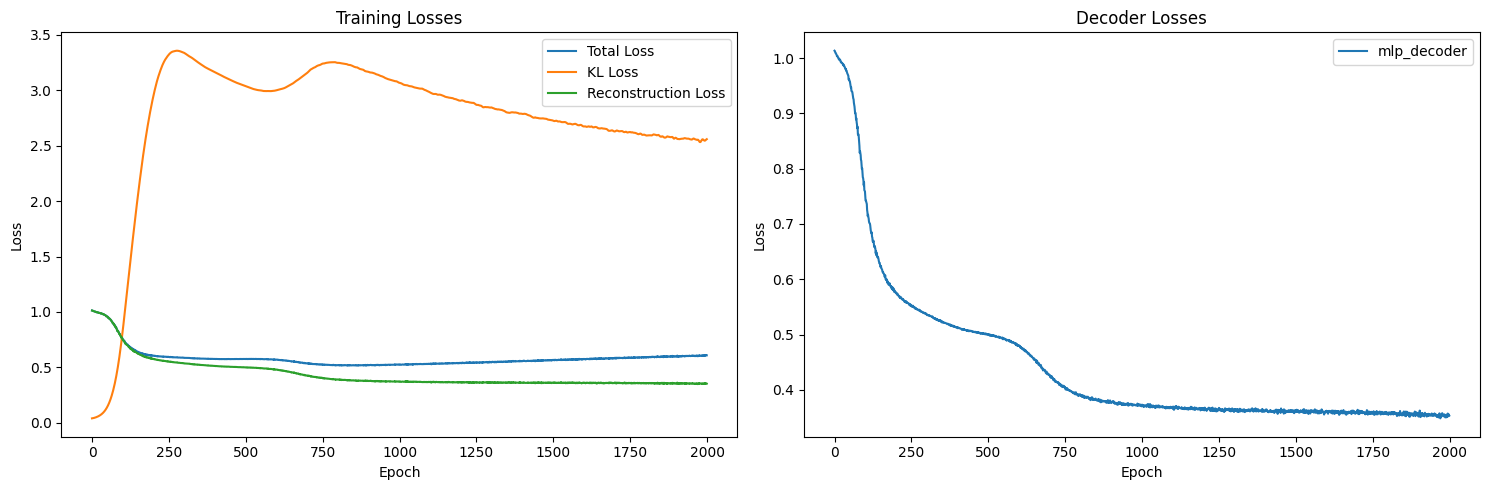

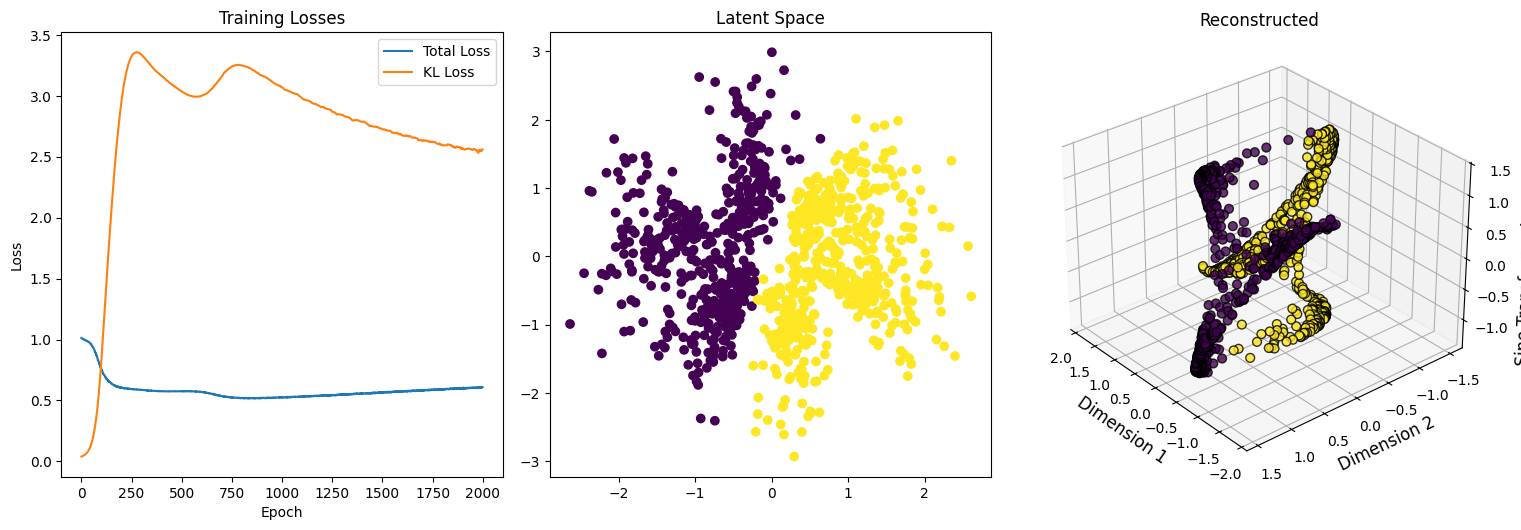

<module 'matplotlib.pyplot' from '/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/matplotlib/pyplot.py'>

In [ ]:
from framework.visuals import visualize_training
visualize_training(history)


def visualize_results(history, latent_repr, recon, communities):
    """Visualize training results and latent space"""
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 3, 1)
    plt.plot(history['total_loss'], label='Total Loss')
    #plt.plot(history['bce_loss'], label='BCE Loss')
    plt.plot(history['kl_loss'], label='KL Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Visualize latent space with t-SNE
    plt.subplot(2, 3, 2)
    #tsne = TSNE(n_components=2, random_state=42)
    #z_tsne = tsne.fit_transform(latent_repr)
    
    #plt.scatter(z_tsne[:,0], z_tsne[:,1], c=communities[:,0])
    plt.scatter(latent_repr[:,0], latent_repr[:,1], c=communities[:,0])
    plt.title('Latent Space')


    ax = plt.subplot(2, 3, 3,  projection='3d', azim=140, elev=30)
    scatter = ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2],
                        c=communities[:,0], cmap='viridis', s=40, alpha=0.8, edgecolor='k')

    # Customization
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    ax.set_zlabel("Sine-Transformed Feature", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()
    
    return plt


# Visualize some reconstructed data
model_usualVAE.eval()
all_latents = []
all_recons = []
all_labels = []

with torch.no_grad():
    for test in test_loader:
        data = test.x 
        labels = test.y
        data = data.to(device)
        latent_mu = model_usualVAE.encode(data)[0]
        recon = model_usualVAE.forward(data)
        
        all_latents.append(latent_mu.cpu())
        all_recons.append(recon["outputs"]["mlp_decoder"]["recon"].cpu())
        all_labels.append(labels.cpu())

# Concatenate everything into full tensors
all_latents = torch.cat(all_latents, dim=0)
all_recons = torch.cat(all_recons, dim=0)
all_labels = torch.cat(all_labels, dim=0)


visualize_results(history,all_latents, all_recons, all_labels.numpy())



## New attempt: incorporating Bounded Manifold Class

In [3]:
import torch
from framework.encoder import MLPEncoder

encoder = MLPEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=encoder_hidden_dims,
    mlp_layers=len(encoder_hidden_dims),
    dropout=dropout,
    activation=torch.nn.ELU(),
    mu_activation=torch.nn.Tanh(),
    variance_dimension=1
)

from framework.decoder import MLPDecoder

decoder = MLPDecoder(
    latent_dim=latent_dim,
    out_dim=input_dim,
    hidden_dims=decoder_hidden_dims,
    dropout=dropout,
    activation=torch.nn.ELU
)

from framework.GraphVAE import KLAnnealingScheduler

kl_scheduler = KLAnnealingScheduler(
    anneal_start=0.0,
    anneal_end=0.1,
    anneal_steps=epochs,
    anneal_type='linear'
)

In [4]:
import torch.nn as nn
from typing import Dict, List, Optional, Tuple, Any, Callable
from abc import ABC, abstractmethod

import gc

from framework.encoder import Encoder
from framework.decoder import DecoderBase
from framework.GraphVAE import KLAnnealingScheduler

from framework.torchVersions.boundedManifold import BoundedManifold


class VAE(nn.Module):
    """
    Flexible VAE model supporting multiple decoders and pluggable priors
    """
    def __init__(
        self,
        encoder: "Encoder",
        decoders: List["DecoderBase"],
        prior: Optional["Prior"] = None,
        kl_scheduler: Optional["KLAnnealingScheduler"] = None,
        freeze_encoder: bool = False,
        compute_latent_manifold: bool = True
    ):
        """
        Args:
            encoder: Encoder modules
            decoders: List of decoder modules
            prior: Prior distribution (defaults to GaussianPrior)
            kl_scheduler: Optional KL annealing scheduler
            freeze_encoder: Whether to freeze the encoder parameters
        """
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoders = nn.ModuleList(decoders)
        self.decoder_dict = {decoder.name: decoder for decoder in decoders}
        self.prior = prior if prior is not None else GaussianPrior()
        self.prior.giveVAEInstance(self)  
        self.kl_scheduler = kl_scheduler if kl_scheduler else KLAnnealingScheduler()

        self.latent_manifold = None
        self.compute_latent_manifold = compute_latent_manifold
        
        # Set encoder freeze state
        self.set_encoder_freeze(freeze_encoder)
        
    def set_encoder_freeze(self, freeze: bool = True):
        """
        Freeze or unfreeze encoder parameters
        
        Args:
            freeze: Whether to freeze encoder parameters
        """
        for param in self.encoder.parameters():
            param.requires_grad = not freeze
            
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode graph into latent space
        
        Args:
            x: Node features [num_nodes, input_dim]
            
        Returns:
            mu: Mean of latent distribution
            params: Distribution parameters (e.g., logvar for Gaussian)
        """
        return self.encoder(x)
    
    def reparameterize(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from latent distribution
        
        Args:
            mu: Mean of latent distribution
            params: Distribution parameters
            
        Returns:
            Sampled latent variables
        """
        return self.prior.sample(mu, params)
    
    def decode(self, z: torch.Tensor, **kwargs) -> Dict[str, Dict[str, torch.Tensor]]:
        """
        Decode latent variables through all active decoders
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict of outputs from each decoder
        """
        all_outputs = {}
        
        for decoder in self.decoders:
            decoder_kwargs = {k: v for k, v in kwargs.items() 
                              if k in decoder.forward.__code__.co_varnames}
            outputs = decoder(z, **decoder_kwargs)
            all_outputs[decoder.name] = outputs
        
        return all_outputs
    
    def forward(self, x: torch.Tensor, **kwargs) -> Dict[str, Any]:
        """
        Full forward pass
        
        Args:
            x: Node features [num_nodes, input_dim]
            **kwargs: Additional decoder-specific arguments
            
        Returns:
            Dict with outputs and latent variables
        """
        # Encode
        mu, params = self.encode(x)

        if self.compute_latent_manifold:
            if self.get_latent_manifold() is None or True:
                manifold_bounds = torch.tensor([[-100, 100]], dtype=torch.float32)
                manifold_bounds = manifold_bounds.repeat(mu.shape[1], 1)
            else:
                manifold_bounds = BoundedManifold.hypercube_bounds(mu, margin=0.6, relative=True)
            self.construct_latent_manifold(manifold_bounds, self.training)
        # Sample latent variables
        z = self.reparameterize(mu, params)
        
        # Decode
        decoder_kwargs = {**kwargs}
        outputs = self.decode(z, **decoder_kwargs)
        
        return {
            "mu": mu,
            "params": params,
            "z": z,
            "outputs": outputs
        }
    
    def compute_loss(
        self, 
        outputs: Dict[str, Any], 
        targets: Dict[str, Dict[str, torch.Tensor]],
        decoder_weights: Optional[Dict[str, float]] = None,
        active_decoders: Optional[List[str]] = None,
        use_custom_losses: bool = True
    ) -> Dict[str, torch.Tensor]:
        """
        Compute total loss from VAE components
        
        Args:
            outputs: Outputs from forward pass
            targets: Target values for each decoder
            decoder_weights: Optional weights for each decoder loss
            active_decoders: Optional list of decoder names to include in loss computation
            use_custom_losses: Whether to include custom decoder losses
            
        Returns:
            Dict with total loss and component losses
        """
        # Default weights if not provided
        if decoder_weights is None:
            decoder_weights = {decoder.name: 1.0 for decoder in self.decoders}
        
        # Use all decoders if active_decoders not specified
        if active_decoders is None:
            active_decoders = list(self.decoder_dict.keys())
        
        # KL divergence loss using pluggable prior
        mu, params = outputs["mu"], outputs["params"]
        kl_loss = self.prior.kl_divergence(mu, params)
        
        # Get current KL weight from scheduler
        kl_weight = self.kl_scheduler.get_weight()
        
        # Compute individual decoder losses
        decoder_losses = {}
        detailed_losses = {}
        weighted_recon_loss = 0
        
        z = outputs["z"]  # Get latent variables for custom losses
        
        for decoder in self.decoders:
            name = decoder.name
            if name not in outputs["outputs"] or name not in active_decoders:
                continue
                
            # Get decoder outputs and corresponding targets
            decoder_outputs = outputs["outputs"][name]
            decoder_targets = targets.get(name, {})
            
            # Compute loss for this decoder (including custom losses if enabled)
            if use_custom_losses and hasattr(decoder, 'compute_total_loss'):
                loss_breakdown = decoder.compute_total_loss(
                    decoder_outputs, decoder_targets, z=z
                )
                decoder_loss = loss_breakdown['total']
                detailed_losses[name] = loss_breakdown
            else:
                decoder_loss = decoder.compute_loss(decoder_outputs, decoder_targets)
                detailed_losses[name] = {'base_loss': decoder_loss, 'total': decoder_loss}
            
            decoder_losses[name] = decoder_loss
            
            # Add weighted loss to total reconstruction loss
            decoder_weight = decoder_weights.get(name, 1.0)
            weighted_recon_loss += decoder_weight * decoder_loss
        
        # Compute total loss
        total_loss = weighted_recon_loss + kl_weight * kl_loss
        
        return {
            "total_loss": total_loss,
            "kl_loss": kl_loss,
            "kl_weight": kl_weight,
            "recon_loss": weighted_recon_loss,
            "decoder_losses": decoder_losses,
            "detailed_losses": detailed_losses
        }
    
    def add_decoder(self, decoder: "DecoderBase"):
        """
        Add a new decoder to the model
        
        Args:
            decoder: Decoder module to add
        """
        self.decoders.append(decoder)
        self.decoder_dict[decoder.name] = decoder
    
    def remove_decoder(self, name: str) -> bool:
        """
        Remove a decoder by name
        
        Args:
            name: Name of the decoder to remove
            
        Returns:
            True if decoder was removed, False if not found
        """
        if name in self.decoder_dict:
            decoder = self.decoder_dict[name]
            self.decoders = nn.ModuleList([d for d in self.decoders if d.name != name])
            self.decoder_dict.pop(name)
            return True
        return False
    
    def get_decoder(self, name: str) -> Optional["DecoderBase"]:
        """
        Get decoder by name
        
        Args:
            name: Name of the decoder
            
        Returns:
            Decoder module or None if not found
        """
        return self.decoder_dict.get(name)
    
    def get_active_decoders(self) -> List[str]:
        """
        Get names of all active decoders
        
        Returns:
            List of decoder names
        """
        return list(self.decoder_dict.keys())
    
    def compute_jacobian(self, z: torch.Tensor, decoder_name: str, node_idx: Optional[int] = None) -> torch.Tensor:
        """
        Compute Jacobian of a specific decoder with respect to latent space
        
        Args:
            z: Latent variables [num_nodes, latent_dim]
            decoder_name: Name of the decoder to compute Jacobian for
            node_idx: Optional node index to compute Jacobian for
            
        Returns:
            Jacobian matrix
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
            
        if hasattr(decoder, "compute_jacobian"):
            return decoder.compute_jacobian(z, node_idx)
        else:
            raise NotImplementedError(f"Decoder '{decoder_name}' does not implement compute_jacobian method")
    
    # Convenience methods for managing custom losses
    def add_custom_loss_to_decoder(self, decoder_name: str, loss_name: str, 
                                  loss_fn: Callable, weight: float = 1.0):
        """
        Add a custom loss to a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name for the custom loss
            loss_fn: Loss function
            weight: Weight for the loss
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is None:
            raise ValueError(f"Decoder '{decoder_name}' not found")
        decoder.add_custom_loss(loss_name, loss_fn, weight)
    
    def remove_custom_loss_from_decoder(self, decoder_name: str, loss_name: str):
        """
        Remove a custom loss from a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss to remove
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.remove_custom_loss(loss_name)
    
    def set_custom_loss_active(self, decoder_name: str, loss_name: str, active: bool = True):
        """
        Activate/deactivate a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            active: Whether the loss should be active
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_active(loss_name, active)
    
    def set_custom_loss_weight(self, decoder_name: str, loss_name: str, weight: float):
        """
        Update the weight of a custom loss for a specific decoder
        
        Args:
            decoder_name: Name of the decoder
            loss_name: Name of the custom loss
            weight: New weight value
        """
        decoder = self.get_decoder(decoder_name)
        if decoder is not None:
            decoder.set_custom_loss_weight(loss_name, weight)

    def _local_decoder_point_metric(self, z, decoder_name: Optional[str] = None) -> torch.Tensor:
        """
        Wrapper to compute the Riemannian metric from the jacobian matrix of decoder_name
        z: numpy array with shape (n,)
        
        Returns an (n x n) metric tensor.
        """
        G = None
        try:
            # Ensure z is a 2D tensor for Jacobian computation (batch_size, n)
            # and specify the output index for the Jacobian
            J = self.compute_jacobian(z, decoder_name, None)
            G = torch.matmul(J.T, J)

        except Exception as e:
            print(f"Error at grid point ({z.numpy()}): {e}") # Convert z to numpy for printing if needed
        
        # If G is still None due to an error, you might want to raise the exception
        # or return None, depending on desired error handling.
        if G is None:
            raise RuntimeError("Riemannian metric computation failed.")
            
        return G
    
    def construct_latent_manifold(self, bounds: torch.Tensor, force : bool = False, cache : bool = True, 
                                  decoder_name: Optional[str] = None) -> BoundedManifold:
        """
        Construct the latent manifold representation

        Args:
            bounds: bounds of the bounded manifold
            force: if True, we construct a new latent manifold in place of the previous one
            decoder_name: Optional name of the decoder to construct the manifold from

        Returns:
            BoundedManifold object 
        """
        if self.latent_manifold is None or force:
            if decoder_name is None:
                decoder_name = list(self.decoder_dict.keys())[0]
            def local_point_metric(z: torch.Tensor) -> torch.Tensor:
                """Local point metric function for the manifold"""
                return self._local_decoder_point_metric(z, decoder_name)
            
            if self.latent_manifold is not None:
                del self.latent_manifold
                gc.collect()
            self.latent_manifold = BoundedManifold(local_point_metric, bounds=bounds, cache=cache, grid_points_per_dim=100)
        return self.latent_manifold

    def get_latent_manifold(self):
        """
        Get the latent manifold representation if available

        Returns:
            BoundedManifold object or None if not initialized
        """
        return self.latent_manifold


class Prior(ABC):
    """Abstract base class for priors"""

    def giveVAEInstance(self, model: VAE):
        self.model = model
    
    @abstractmethod
    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Sample from the prior distribution"""
        pass
    
    @abstractmethod
    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """Compute KL divergence with respect to the prior"""
        pass
    
    @abstractmethod
    def get_param_size(self) -> int:
        """Return the number of parameters needed (e.g., 1 for logvar, 2 for concentration)"""
        pass

class GaussianPrior(Prior):
    """Gaussian prior N(0, I)"""
    
    def sample(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        if mu.device != logvar.device:
            logvar = logvar.to(mu.device)
        
        if mu.requires_grad:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def kl_divergence(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    def get_param_size(self) -> int:
        return 1  # logvar




In [5]:
import time

from framework.torchVersions.distanceApproximations import DistanceApproximations

class RiemannianPrior(Prior):
    """Riemannian Brownian motion prior on latent manifold"""
    def __init__(self, variance: float = 1,
        distance_mode: str = "linear_interpolation",  # or "direct"
        num_integration_points: int = 10,
        ):
        """
        Args:
            variance: diffusion time parameter t controlling spread of Brownian motion
        """
        self._reference_decoder = None
        self.variance = variance

        self.distance_mode = distance_mode
        self.num_integration_points = num_integration_points

    def sample(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Sample via discretized Brownian motion on the Riemannian manifold.
        Args:
            mu: variational means [batch, latent_dim]
            params: variational diffusion times t_q [batch] or scalar
        Returns:
            Sampled latent codes [batch, latent_dim]
        """
        # perform Brownian motion sampling step(s)
        # user must implement this method's core: leveraging Riemannian metric
        self.model.get_latent_manifold().compute_full_grid_metric_tensor()
        return self.brownian_step(mu, params)

    def kl_divergence(self, mu: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
        """
        Estimate Monte Carlo KL divergence between variational heat kernel centered at mu
        and Riemannian Brownian prior centered at zero (or another reference).
        Args:
            mu: variational means [batch, latent_dim]
            params: tuple of (t_q,) variational diffusion times
        Returns:
            KL divergence scalar
        """
        # user will implement using geodesic distances and volume measures
        t_q = params
        t_q = torch.exp(t_q)
        for i in range(t_q.shape[0]):
            if torch.isnan(t_q[i]).any() or (t_q[i] <= 0).any():
                t_q[i] = torch.tensor(1e-4, device=t_q.device)  
        self.model.get_latent_manifold().compute_full_grid_metric_tensor()
        return self._estimate_kl(mu, t_q, self.variance)

    def get_param_size(self) -> int:
        # only a single diffusion time parameter for the Riemannian prior
        return 1

    def brownian_step(self, z0: torch.Tensor, t: torch.Tensor, n_steps: int = 10) -> torch.Tensor:
        #print(f"[brownian_step] Starting with batch size {z0.shape[0]} and {n_steps} steps")
        z = z0
        if t.dim() == 1:
            t = t.view(-1, 1, 1)

        t = torch.exp(t)
        t = t.sum(dim=1)
        dt = t / n_steps
        for step in tqdm(range(n_steps), desc="Brownian Steps"):
            #print(f"[brownian_step] Step {step+1}/{n_steps}")
            new_z_elements = []
            for i in range(z.shape[0]):
                z_i = z[i:i+1].squeeze(0)
                metric_start = time.time()
                G = self.model.get_latent_manifold().metric_tensor(z_i)
                # Ensure numerical stability
                G += 1e-6 * torch.eye(G.shape[0], device=G.device)
                if torch.isnan(G).any():
                    print(f"[NaN] Metric tensor at z_i is NaN: z_i = {z_i}")
                    G = torch.eye(G.shape[0], device=G.device)
                G_inv_i = torch.linalg.inv(G)
                #print(f"  [step {step+1}] G_inv computed in {time.time() - metric_start:.4f}s for sample {i}")

                xi_i = torch.randn_like(z_i).unsqueeze(-1)
                if torch.isnan(dt[i]).any() or (dt[i] <= 0).any():
                    print(f"[Error] Invalid dt at step {step}, i = {i}: {dt[i]}")
                    dt[i] = torch.tensor(1e-4, device=dt.device)  # safe fallback
                increment_i = dt[i] * (G_inv_i @ xi_i).squeeze(-1)
                new_z_i = z_i + increment_i
                new_z_i = self.model.get_latent_manifold()._clamp_point_to_bounds(new_z_i)
                new_z_elements.append(new_z_i)

            z = torch.stack(new_z_elements, dim=0)
        #print("[brownian_step] Finished")
        return z


    def _estimate_kl(self, mu: torch.Tensor, t_q: torch.Tensor, t_p: float) -> torch.Tensor:
        #print(f"[KL] Estimating KL with batch size {mu.shape[0]}")
        start_time = time.time()
        z_samples = self.brownian_step(mu, t_q)
        N, d = z_samples.shape[0], z_samples.shape[1]
        mu_p = torch.zeros_like(mu)
        mu_q = mu
        total = 0.0
        t_q = t_q.sum(dim=1)
        log_t_p = torch.log(torch.tensor(t_p, device=t_q.device))
        for i in tqdm(range(N), desc="Estimating KL"):
            d_q2 = self._riemannian_distance(z_samples[i].unsqueeze(0), mu_q[i].unsqueeze(0)).pow(2).squeeze()
            d_p2 = self._riemannian_distance(z_samples[i].unsqueeze(0), mu_p[i].unsqueeze(0)).pow(2).squeeze()

            _, logdet_mu_q = torch.slogdet(self.model.get_latent_manifold().metric_tensor(mu_q[i]))
            _, logdet_mu_p = torch.slogdet(self.model.get_latent_manifold().metric_tensor(mu_p[i]))

            term = (logdet_mu_p - logdet_mu_q)
            #print(f"  [KL] Sample {i}: term = {term.item():.4f}, logdet_mu_p = {logdet_mu_p.item():.4f}, logdet_mu_q = {logdet_mu_q.item():.4f}")
            term += d * (torch.log(t_q[i]) - log_t_p)
            #print(f"  [KL] Sample {i}: term = {term.item():.4f}, d = {d}, log_t_q = {torch.log(t_q[i]).item():.4f}, log_t_p = {log_t_p.item():.4f}")
            term += d_p2 / t_p  -  d_q2 / (t_q[i].squeeze())
            #print(f"  [KL] Sample {i}: term = {term.item():.4f}, d_p2 = {d_p2.item():.4f}, d_q2 = {d_q2.item():.4f}, t_p = {t_p:.4f}, t_q[i] = {t_q[i].item():.4f}")
            total += term
            #print(f"  [KL] Sample {i}: term = {term.item():.4f}")

        total = 0.5 * total / N
        #print(f"[KL] Done in {time.time() - start_time:.4f}s")
        return total
        
    def _riemannian_distance(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
        #print(f"[riemannian_distance] Computing pairwise distances for batch size {z.shape[0]}")
        start_time = time.time()
        distances = []
        for i, (u_vec, v_vec) in enumerate(zip(z, mu)):
            if self.distance_mode == "linear_interpolation":
                d = DistanceApproximations.linear_interpolation_distance(self.model.get_latent_manifold(), u_vec, v_vec, 
                                                                         num_points=self.num_integration_points)
            else:
                d = self.model.get_latent_manifold().exact_geodesic_distance(u_vec, v_vec)
            #print(f"  [distance] Sample {i}: {d.item():.4f}")
            distances.append(d)
        #print(f"[riemannian_distance] Done in {time.time() - start_time:.4f}s")
        return torch.stack(distances)

    def volume_ratio(self, z: torch.Tensor, mu: torch.Tensor) -> torch.Tensor:
        """
        Compute volume measure ratio term H0 = sqrt(det G(z) / det G(mu)).
        Args:
            z: points [batch, latent_dim]
            mu: centers [batch, latent_dim]
        Returns:
            ratios: [batch]
        """
        if self._reference_decoder is None:
            self.set_reference_decoder(self.model.get_active_decoders()[0])  

        ratios = []
        for z_pt, mu_pt in zip(z, mu):
            G_z = self.model.get_latent_manifold().metric_tensor(z_pt)
            G_mu = self.model.get_latent_manifold().metric_tensor(mu_pt)
            # use slogdet for stability
            sign_z, logdet_z = torch.slogdet(G_z)
            sign_mu, logdet_mu = torch.slogdet(G_mu)
            # ratio = exp(0.5 * (logdet_z - logdet_mu))
            r = torch.exp(0.5 * (logdet_z - logdet_mu))
            ratios.append(r)
        return torch.stack(ratios)


In [ ]:
from tqdm import tqdm
model_usualVAE = VAE(
    encoder=encoder,
    decoders=[decoder],
    #kl_scheduler=kl_scheduler,
    prior=RiemannianPrior()
)
lr = 1e-4
verbose = False


model_usualVAE = model_usualVAE.to(device)
optimizer = torch.optim.Adam(model_usualVAE.parameters(), lr=lr, weight_decay=1e-5)

history = {
    "total_loss": [],
    "kl_loss": [],
    "recon_loss": [],
    "decoder_losses": {"mlp_decoder": []}
}

# Training loop
for epoch in range(epochs):
    epoch_losses = {
        "total_loss": 0.0,
        "kl_loss": 0.0,
        "recon_loss": 0.0,
        "decoder_losses": {"mlp_decoder": 0.0}
    }
    
    num_batches = 0
    
    # Process batches
    iterator = tqdm(train_loader) if verbose else train_loader
    for batch in iterator:
        print("==="*20)
        print("EPOCH ", epoch)
        num_batches += 1
        
        # Move batch to device
        x = batch.x.to(device)
        
        # Create fully connected edge index
        num_nodes = x.size(0)
        
        # Forward pass with fully connected edge index
        model_usualVAE.train()
        optimizer.zero_grad()
        outputs = model_usualVAE(x)
        
        targets = {
            "mlp_decoder": {
                    "x": x
            }
        }
        active_decoders = ["mlp_decoder"]
        
        # Compute loss
        loss_dict = model_usualVAE.compute_loss(outputs, targets, active_decoders=active_decoders)
        
        # Backward pass
        loss_dict["total_loss"].backward()
        optimizer.step()
        
        # Step KL annealing scheduler
        model_usualVAE.kl_scheduler.step()
        
        # Update epoch losses
        epoch_losses["total_loss"] += loss_dict["total_loss"].item()
        epoch_losses["kl_loss"] += loss_dict["kl_loss"].item()
        epoch_losses["recon_loss"] += loss_dict["recon_loss"].item()
        
        for name, loss in loss_dict["decoder_losses"].items():
            epoch_losses["decoder_losses"][name] += loss.item()
    
    # Compute average losses
    for key in ["total_loss", "kl_loss", "recon_loss"]:
        epoch_losses[key] /= num_batches
        history[key].append(epoch_losses[key])
    
    for name in epoch_losses["decoder_losses"]:
        epoch_losses["decoder_losses"][name] /= num_batches
        history["decoder_losses"][name].append(epoch_losses["decoder_losses"][name])
    
    # Print epoch summary
    if (epoch + 1) % 10 == 0:
        kl_weight = model_usualVAE.kl_scheduler.get_weight()
        print(f"Phase 1 - Epoch {epoch+1}/{epochs} - "
                f"Loss: {epoch_losses['total_loss']:.4f}, "
                f"KL: {epoch_losses['kl_loss']:.4f} (weight: {kl_weight:.4f}), "
                f"Node Recon: {epoch_losses['decoder_losses']['mlp_decoder']:.4f}")



EPOCH  0


Computing metric tensors: 100%|██████████| 10000/10000 [00:01<00:00, 7764.23it/s]


Full grid metric tensor computation complete.


Brownian Steps: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Full grid metric tensor has already been computed. Use 'force=True' to recompute.


Estimating KL: 100%|██████████| 4000/4000 [00:12<00:00, 322.92it/s]


EPOCH  1


Computing metric tensors: 100%|██████████| 10000/10000 [00:01<00:00, 8442.65it/s]


Full grid metric tensor computation complete.


Brownian Steps: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Full grid metric tensor has already been computed. Use 'force=True' to recompute.


Estimating KL: 100%|██████████| 4000/4000 [00:14<00:00, 274.32it/s]


EPOCH  2


Computing metric tensors: 100%|██████████| 10000/10000 [00:01<00:00, 8103.55it/s]


Full grid metric tensor computation complete.


Brownian Steps: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Full grid metric tensor has already been computed. Use 'force=True' to recompute.


Estimating KL: 100%|██████████| 4000/4000 [00:15<00:00, 257.76it/s]


In [1]:
from framework.visuals import visualize_training
visualize_training(history)


def visualize_results(history, latent_repr, recon, communities):
    """Visualize training results and latent space"""
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 3, 1)
    plt.plot(history['total_loss'], label='Total Loss')
    #plt.plot(history['bce_loss'], label='BCE Loss')
    plt.plot(history['kl_loss'], label='KL Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Visualize latent space with t-SNE
    plt.subplot(2, 3, 2)
    #tsne = TSNE(n_components=2, random_state=42)
    #z_tsne = tsne.fit_transform(latent_repr)
    
    #plt.scatter(z_tsne[:,0], z_tsne[:,1], c=communities[:,0])
    plt.scatter(latent_repr[:,0], latent_repr[:,1], c=communities[:,0])
    plt.title('Latent Space')


    ax = plt.subplot(2, 3, 3,  projection='3d', azim=140, elev=30)
    scatter = ax.scatter(recon[:, 0], recon[:, 1], recon[:, 2],
                        c=communities[:,0], cmap='viridis', s=40, alpha=0.8, edgecolor='k')

    # Customization
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    ax.set_zlabel("Sine-Transformed Feature", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()
    
    return plt


# Visualize some reconstructed data
model_usualVAE.eval()
all_latents = []
all_recons = []
all_labels = []

with torch.no_grad():
    for test in test_loader:
        data = test.x 
        labels = test.y
        data = data.to(device)
        latent_mu = model_usualVAE.encode(data)[0]
        recon = model_usualVAE.forward(data)
        
        all_latents.append(latent_mu.cpu())
        all_recons.append(recon["outputs"]["mlp_decoder"]["recon"].cpu())
        all_labels.append(labels.cpu())

# Concatenate everything into full tensors
all_latents = torch.cat(all_latents, dim=0)
all_recons = torch.cat(all_recons, dim=0)
all_labels = torch.cat(all_labels, dim=0)


visualize_results(history,all_latents, all_recons, all_labels.numpy())



/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

NameError: name 'history' is not defined

In [ ]:
model_usualVAE.get_latent_manifold()._n_dimensions

2

Computing metric tensors: 100%|██████████| 100/100 [00:00<00:00, 5944.56it/s]


Full grid metric tensor computation complete.


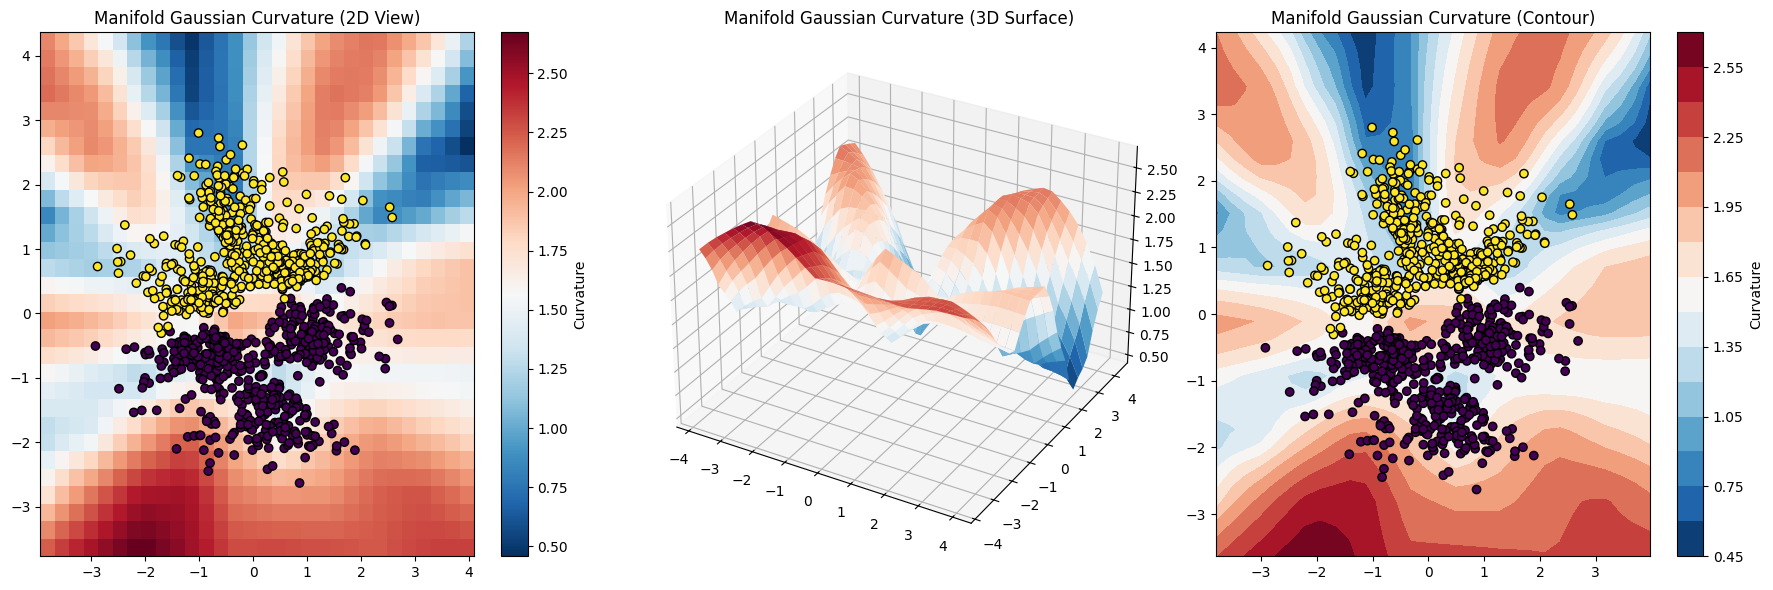

In [ ]:
model_usualVAE.get_latent_manifold().compute_full_grid_metric_tensor()
model_usualVAE.get_latent_manifold().visualize_manifold_curvature(exact_mode=False, data_points=all_latents, labels=all_labels)